In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import math
import time
import heapq

In [2]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (18, 12)

In [3]:
class CustomRandom:
    def __init__(self, seed=int(time.time())):
        self.seed = seed
        self.a = 1664525
        self.c = 1013904223
        self.m = 2**32

    def uniform(self):
        self.seed = (self.a * self.seed + self.c) % self.m
        return self.seed / self.m

    def uniform_range(self, a, b):
        u = self.uniform()
        return a + (b - a) * u

    # Метод Бокса-Мюллера
    def normal_box_muller(self, mu, sigma):
        u1 = self.uniform()
        u2 = self.uniform()
        z0 = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
        z1 = math.sqrt(-2.0 * math.log(u1)) * math.sin(2.0 * math.pi * u2)
        return mu + z0 * sigma

    # Метод обратного преобразования
    def exponential_inverse_transform(self, beta):
        return -beta * math.log(self.uniform())

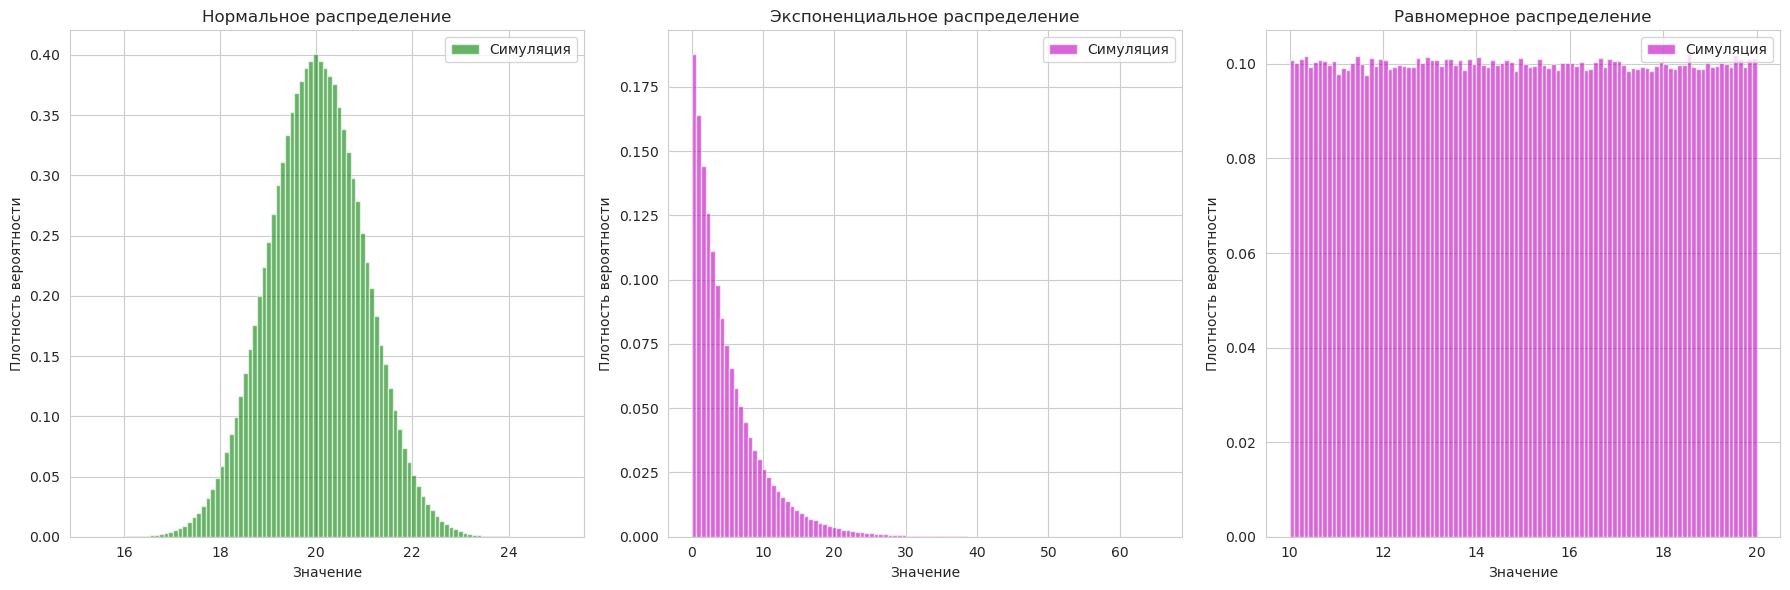

In [4]:
def simulate_distributions(num_samples=1_000_000, mu=20, sigma=1, beta=5):
    random_gen = CustomRandom()
    
    normal_samples = [random_gen.normal_box_muller(mu, sigma) for _ in range(num_samples)]

    exponential_samples = [random_gen.exponential_inverse_transform(beta) for _ in range(num_samples)]

    uniform_samples = [random_gen.uniform_range(10, 20) for _ in range(num_samples)]
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.hist(normal_samples, bins=100, density=True, alpha=0.6, color='g', label='Симуляция')
    plt.title('Нормальное распределение')
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(exponential_samples, bins=100, density=True, alpha=0.6, color='m', label='Симуляция')
    plt.title('Экспоненциальное распределение')
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.hist(uniform_samples, bins=100, density=True, alpha=0.6, color='m', label='Симуляция')
    plt.title('Равномерное распределение')
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.legend()

    plt.tight_layout()
    plt.show()

simulate_distributions()

In [5]:
class Request:
    def __init__(self, time, custom_random, mean_amount=1, std_amount=0.5, mean_distance=40, std_distance=5):
        self.wait = 0
        self.time = time
        self.custom_random = custom_random
        self.amount = self.custom_random.normal_box_muller(mean_amount, std_amount)
        self.distance = self.custom_random.normal_box_muller(mean_distance, std_distance)

In [6]:
class RandomGenerate:
    def __init__(self, params):
        self.params = params
        self.custom_random = CustomRandom()

    def generate_requests(self):
        request_times = []
        for _ in range(self.params['request_intensity']):
            time = self.custom_random.exponential_inverse_transform(24 / self.params['request_intensity'])
            request_times.append(Request(time, self.custom_random))
        return sorted(request_times, key=lambda r: r.time)

In [7]:
class Warehouse:
    def __init__(self, capacity):
        self.capacity = capacity
        self.stored = 0.0
    
    def store(self, amount):
        self.stored = min(self.capacity, self.stored + amount)
        return self.stored

In [8]:
class CollectionProcess:
    def __init__(self, params):
        self.params = params

    def collect(self, request):
        time = request.distance / self.params['vehicle_speed'] + request.amount / self.params['loader_speed']
        return time

In [9]:
class TransportationProcess:
    def __init__(self, params):
        self.params = params
    
    def transport(self, request):
        time = request.distance / self.params['vehicle_speed']
        return time

In [10]:
class RecyclingProcess:
    def __init__(self, params):
        self.params = params
        self.factory_time = params['factory_time']

    # each 1 hour
    def process(self, amount):
        if self.factory_time > 0:
            self.factory_time-=1
            return min(amount, self.params['factory_recycling']) * self.params['factory_efficiency']
        else:
            return 0

In [11]:
class WasteManagementSystem:
    def __init__(self, params):
        self.params = params
        self.collection = CollectionProcess(params)
        self.transporter = TransportationProcess(params)
        self.recycling = RecyclingProcess(params)
        self.random = RandomGenerate(params)
        self.custom_random = CustomRandom()
        self.warehouses = {
            'raw': Warehouse(params['warehouse_capacity']),
            'recycled': Warehouse(params['warehouse_capacity'])
        }
        self.metrics = {
            'wait_times': [],
            'recycled': [],
            'amounts': [],
            'distances': [],
            'finish_request': [],
            'raw': [],
            'request_time': []
        }
        self.num_machines = 10
        self.free_machines = 10
        self.busy_until = []  # Очередь для отслеживания времени, когда машины будут свободны
    
    def simulate_day(self):
        requests = self.random.generate_requests()
        current_time = 0.0
        
        for request in requests:

            self.metrics['distances'].append(request.distance)
            self.metrics['amounts'].append(request.amount)
            self.metrics['request_time'].append(request.time)
            
            if self.free_machines > 0:
                self.free_machines -= 1
                finish_time = request.time + self.collection.collect(request) + self.transporter.transport(request)
                heapq.heappush(self.busy_until, finish_time)  # Добавляем время завершения в очередь
                self.metrics['wait_times'].append(0)
                self.metrics['finish_request'].append(finish_time)
                current_time = finish_time
            else:
                # Если нет свободных машин, определяем, когда заявка будет обработана
                next_free_time = heapq.heappop(self.busy_until)  # Время, когда следующая машина будет свободна
                wait_time = next_free_time - request.time
                finish_time = next_free_time + self.collection.collect(request) + self.transporter.transport(request)  # Время завершения обработки
                heapq.heappush(self.busy_until, finish_time)  # Добавляем новое время завершения
                self.metrics['wait_times'].append(wait_time)
                self.metrics['finish_request'].append(finish_time)
                current_time = finish_time

            self.warehouses['raw'].store(request.amount)
            self.metrics['raw'].append(self.warehouses['raw'].stored)

            while self.recycling.factory_time > 0 and self.warehouses['raw'].stored > 0:
                recycled = self.recycling.process(self.custom_random.uniform_range(self.warehouses['raw'].stored, self.warehouses['raw'].stored + 1))
                self.warehouses['recycled'].store(request.amount)
                self.metrics['recycled'].append(self.warehouses['recycled'].stored)
                self.warehouses['raw'].store(request.amount * -1)
        
        return self.metrics

In [12]:
# Параметры системы
params = {
    'request_intensity': 50,
    'n_vehicles': 10,
    'vehicle_capacity': 10,
    'vehicle_speed': 50,
    'factory_capacity': 0.5,
    'factory_efficiency': 0.8,
    'warehouse_capacity': 200,
    'factory_time': 12,
    'factory_recycling': 0.5,
    'loader_speed': 0.5
}

# Проведение симуляций
n_simulations = 1_000
results = []

for _ in tqdm(range(n_simulations), desc="Прогресс симуляции"):
    system = WasteManagementSystem(params)
    results.append(system.simulate_day())

Прогресс симуляции: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5971.84it/s]


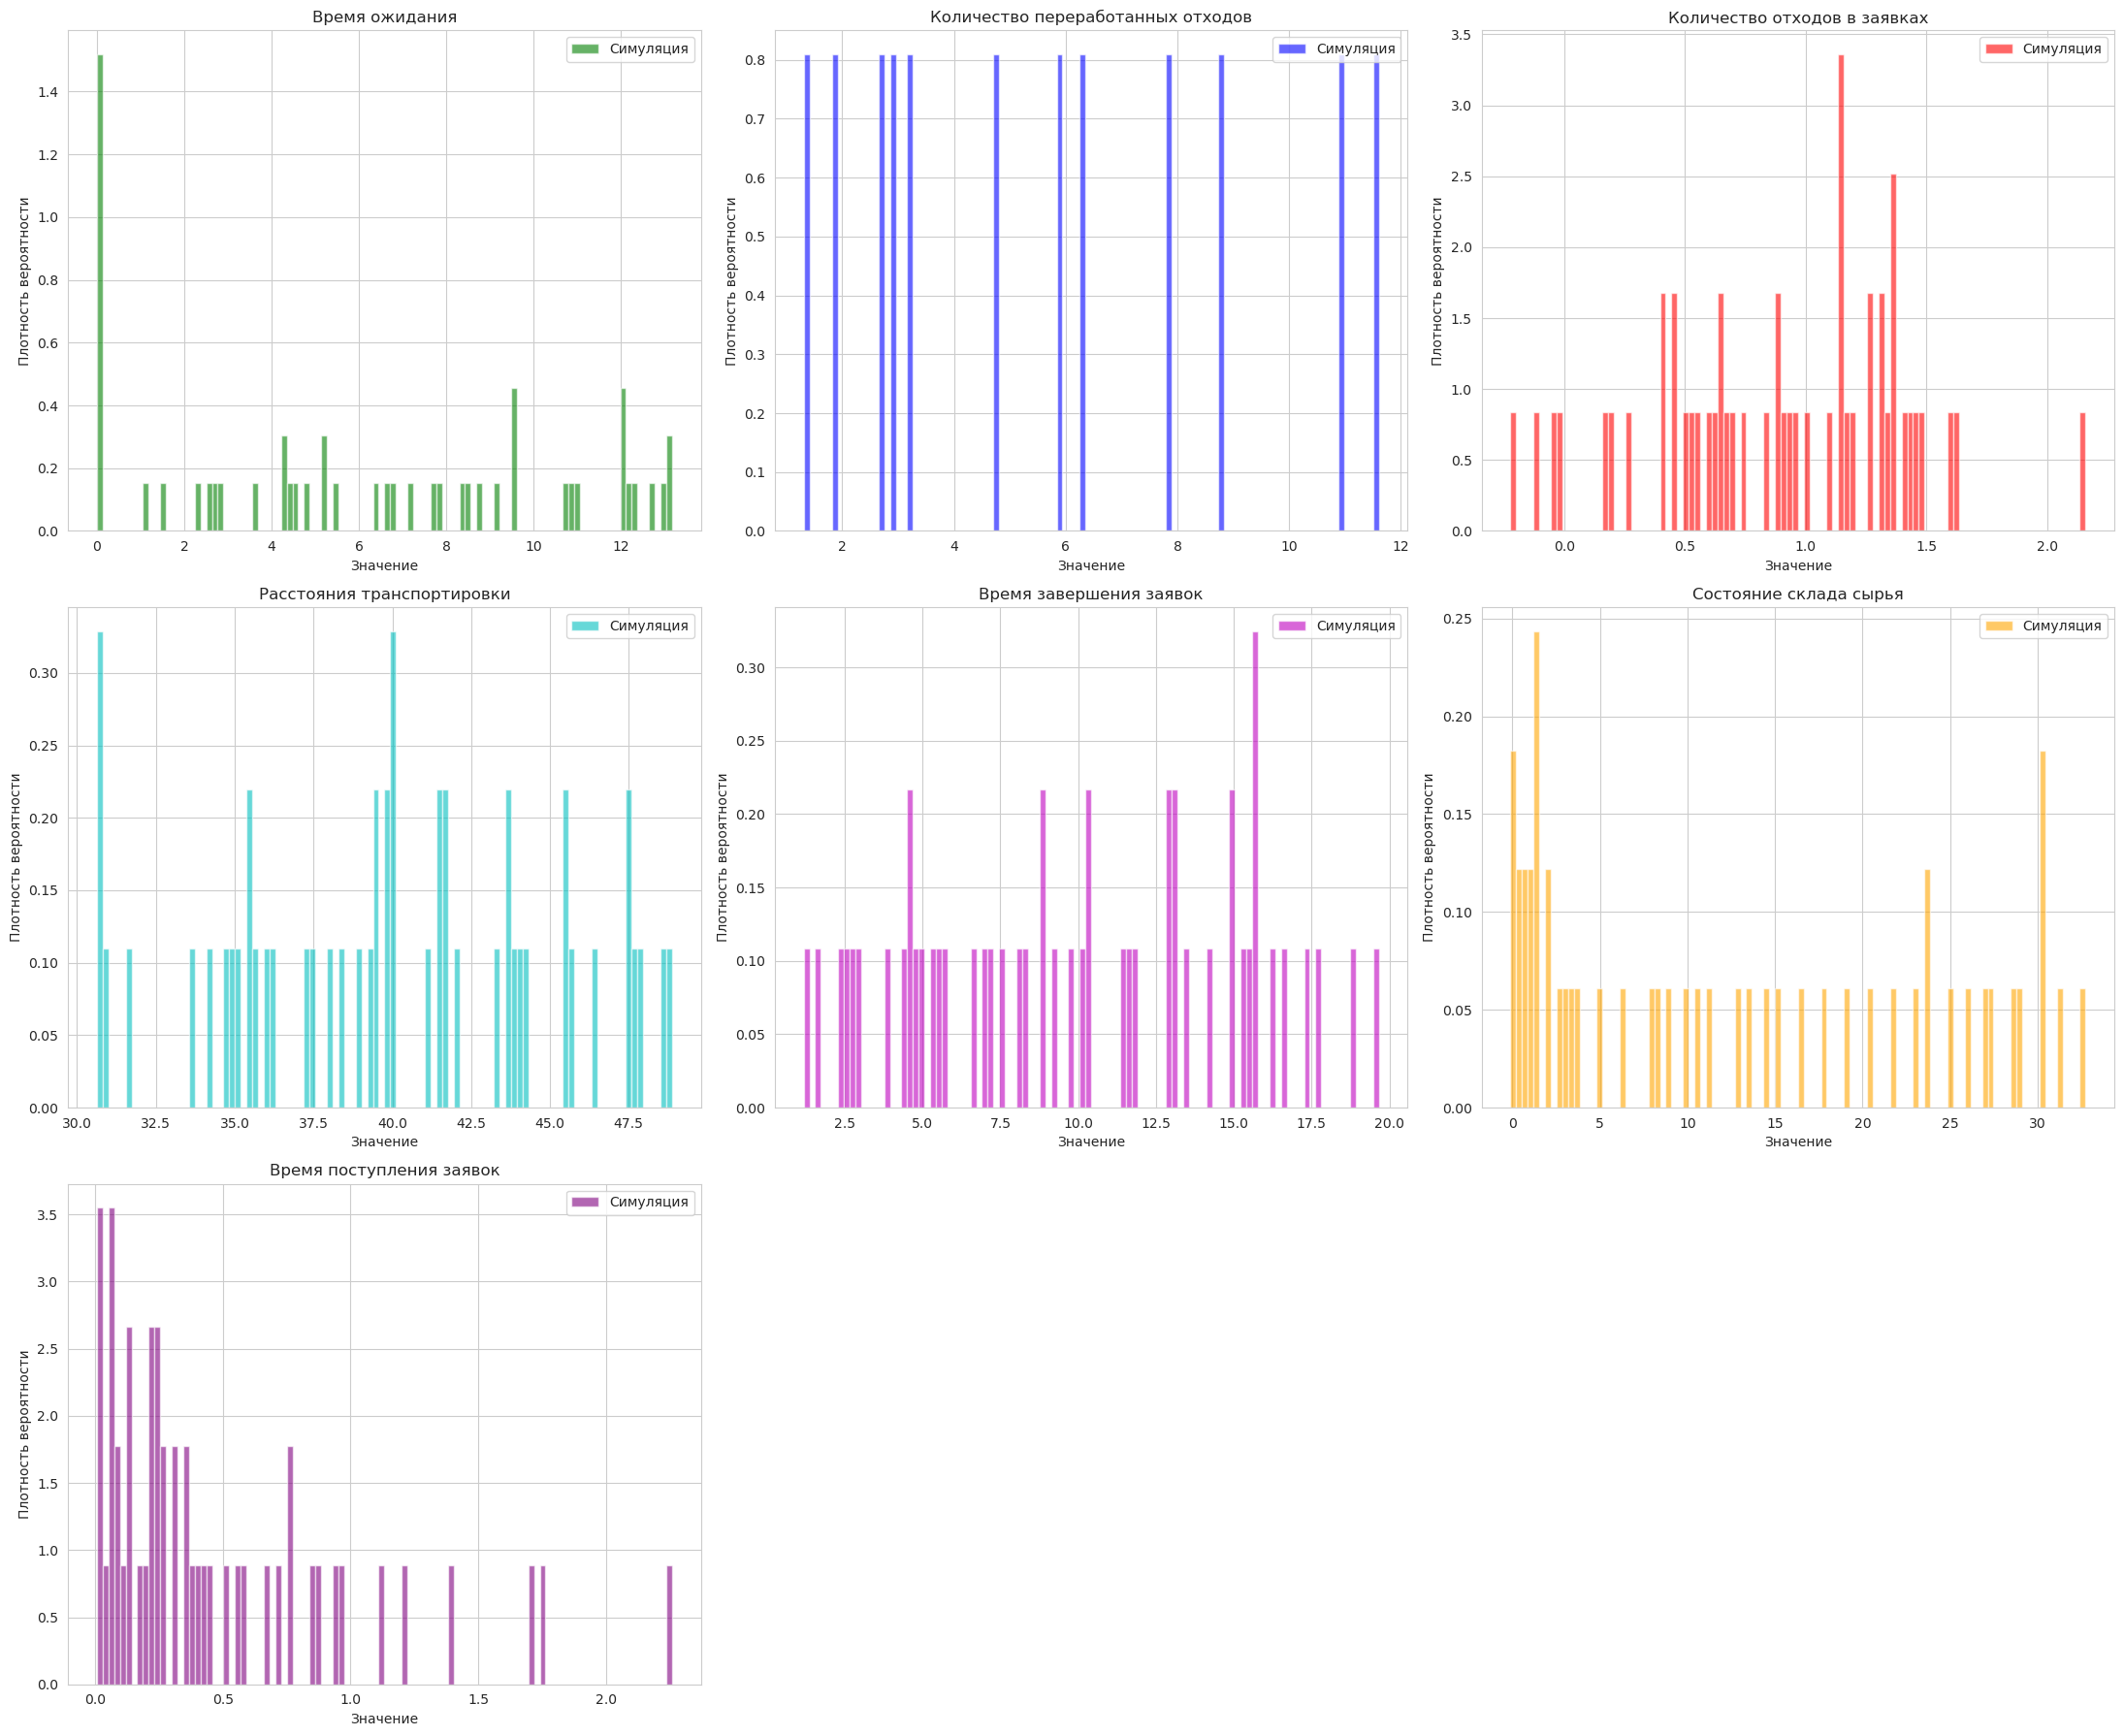

In [13]:
# ВЕЛИКИЙ СБОР ГРАФИКОВ ДЛЯ СТАТИСТИКИ
# Сбор данных из всех симуляций
wait_times = [result['wait_times'] for result in results]
recycled_amounts = [result['recycled'] for result in results]
amounts = [result['amounts'] for result in results]
distances = [result['distances'] for result in results]
finish_requests = [result['finish_request'] for result in results]
raw_states = [result['raw'] for result in results]
request_times = [result['request_time'] for result in results]

# Преобразуем в плоские списки
wait_times_flat = [item for sublist in wait_times for item in sublist]
recycled_amounts_flat = [item for sublist in recycled_amounts for item in sublist]
amounts_flat = [item for sublist in amounts for item in sublist]
distances_flat = [item for sublist in distances for item in sublist]
finish_requests_flat = [item for sublist in finish_requests for item in sublist]
raw_states_flat = [item for sublist in raw_states for item in sublist]
request_times_flat = [item for sublist in request_times for item in sublist]

# Построение графиков
plt.figure(figsize=(22, 18))

# График времени ожидания
plt.subplot(3, 3, 1)
plt.hist(wait_times_flat, bins=100, density=True, alpha=0.6, color='g', label='Симуляция')
plt.title('Время ожидания')
plt.xlabel('Значение')
plt.ylabel('Плотность вероятности')
plt.legend()

# График количества переработанных отходов
plt.subplot(3, 3, 2)
plt.hist(recycled_amounts_flat, bins=100, density=True, alpha=0.6, color='b', label='Симуляция')
plt.title('Количество переработанных отходов')
plt.xlabel('Значение')
plt.ylabel('Плотность вероятности')
plt.legend()

# График количества отходов в заявках
plt.subplot(3, 3, 3)
plt.hist(amounts_flat, bins=100, density=True, alpha=0.6, color='r', label='Симуляция')
plt.title('Количество отходов в заявках')
plt.xlabel('Значение')
plt.ylabel('Плотность вероятности')
plt.legend()

# График расстояний транспортировки
plt.subplot(3, 3, 4)
plt.hist(distances_flat, bins=100, density=True, alpha=0.6, color='c', label='Симуляция')
plt.title('Расстояния транспортировки')
plt.xlabel('Значение')
plt.ylabel('Плотность вероятности')
plt.legend()

# График времени завершения заявок
plt.subplot(3, 3, 5)
plt.hist(finish_requests_flat, bins=100, density=True, alpha=0.6, color='m', label='Симуляция')
plt.title('Время завершения заявок')
plt.xlabel('Значение')
plt.ylabel('Плотность вероятности')
plt.legend()

# График состояния склада сырья
plt.subplot(3, 3, 6)
plt.hist(raw_states_flat, bins=100, density=True, alpha=0.6, color='orange', label='Симуляция')
plt.title('Состояние склада сырья')
plt.xlabel('Значение')
plt.ylabel('Плотность вероятности')
plt.legend()

# График времени поступления заявок
plt.subplot(3, 3, 7)
plt.hist(request_times_flat, bins=100, density=True, alpha=0.6, color='purple', label='Симуляция')
plt.title('Время поступления заявок')
plt.xlabel('Значение')
plt.ylabel('Плотность вероятности')
plt.legend()

plt.tight_layout()
plt.show()